In [9]:
import os
import re
import glob
import logging

# Mute Warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import pandas as pd
import librosa
import tensorflow_hub as hub
import tensorflow as tf
import joblib
import mlflow
import mlflow.sklearn
from transformers import pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- KONFIGURASI ---
SOURCE_DIRS = ['../../../data/raw', '../../../data/raw2'] # Update: Multi-folder
LYRICS_PATH = '../../../data/lyrics/lyrics.xlsx' # Update: Excel
TARGET_MOODS = ['angry', 'happy'] 
MODEL_NAME = "j-hartmann/emotion-english-distilroberta-base"
FOLDS = 5
SEED = 43 # Tetap 43

# MLflow Setup
MLFLOW_TRACKING_URI = r"file:///C:/CAWU4GROUP3/projects/projectRoodio/machineLearning/mlruns"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Hierarchical_Stage2A_AngryHappy")

print(f"🚀 MEMULAI EXP 27: STACKING ENSEMBLE (ANGRY vs HAPPY)...")

# --- 1. SETUP & CLEANING DATA ---
# Load Excel (Update Logic)
try:
    df = pd.read_excel(LYRICS_PATH)
    # Pastikan ID & Mood format string
    df['id'] = df['id'].astype(str).str.strip()
    df['mood'] = df['mood'].str.lower().str.strip()
    
    # Filter Mood
    df = df[df['mood'].isin(TARGET_MOODS)].copy()
    
    # Mapping Cepat (ID -> Lyrics)
    lyrics_map = pd.Series(df.lyrics.values, index=df.id).to_dict()
    mood_map = pd.Series(df.mood.values, index=df.id).to_dict()
    
    print(f"📊 Data Excel Loaded: {len(df)} baris valid.")
except Exception as e:
    print(f"❌ Error loading Excel: {e}")
    exit()

c:\Users\andiz\anaconda3\envs\roodio-env\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


🚀 MEMULAI EXP 27: STACKING ENSEMBLE (ANGRY vs HAPPY)...
📊 Data Excel Loaded: 100 baris valid.


In [3]:
# === FUNGSI PREPROCESSING LIRIK (TETAP) ===
def clean_lyrics_text(text):
    if pd.isna(text) or text == '':
        return ""
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', ' ', text) 
    text = re.sub(r'\(.*?\)', ' ', text) 
    garbage = ['lyrics', 'embed', 'contributors', 'translation']
    for w in garbage:
        text = text.replace(w, '')
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r"[^a-z0-9\s.,'!?]", '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Cleaning Lirik di Memory (Dictionary)
for pid in lyrics_map:
    lyrics_map[pid] = clean_lyrics_text(lyrics_map[pid])

print("✅ Lirik berhasil dibersihkan.")

# Load Models
print("⏳ Loading Models (YAMNet & RoBERTa)...")
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")
nlp_classifier = pipeline("text-classification", model=MODEL_NAME, top_k=None, truncation=True)

✅ Lirik berhasil dibersihkan.
⏳ Loading Models (YAMNet & RoBERTa)...




Loading weights: 100%|██████████| 105/105 [00:00<00:00, 714.37it/s, Materializing param=roberta.encoder.layer.5.output.dense.weight]             
RobertaForSequenceClassification LOAD REPORT from: j-hartmann/emotion-english-distilroberta-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [4]:
# --- 2. FEATURE EXTRACTION ---
X_audio_features = []
X_text_scores = [] 
y_labels = []
titles_log = []

print("🧠 Extracting Features (Multi-Source)...")

def extract_audio(path):
    try:
        y, sr = librosa.load(path, sr=16000)
        if len(y) < 16000: y = np.pad(y, (0, 16000-len(y)))
        _, emb, _ = yamnet_model(y)
        yamnet_vec = tf.reduce_mean(emb, axis=0).numpy()
        rms = np.mean(librosa.feature.rms(y=y))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
        return np.concatenate([yamnet_vec, [rms, zcr]])
    except: return None

def get_text_scores(lyrics):
    try:
        lyrics_chunk = str(lyrics)[:512]
        output = nlp_classifier(lyrics_chunk)[0]
        scores = {item['label']: item['score'] for item in output}
        s_happy = scores.get('joy', 0) + scores.get('surprise', 0)
        s_angry = scores.get('anger', 0) + scores.get('disgust', 0) + scores.get('fear', 0)
        return [s_angry, s_happy] 
    except: return [0.5, 0.5]

def get_id_from_filename(filename):
    base = os.path.basename(filename)
    parts = base.split('_')
    if len(parts) > 1: return parts[0].strip()
    return None

🧠 Extracting Features (Multi-Source)...


In [5]:
# Kumpulkan File Audio (Rekursif)
all_audio_files = []
for d in SOURCE_DIRS:
    all_audio_files.extend(glob.glob(os.path.join(d, "**", "*.wav"), recursive=True))
    all_audio_files.extend(glob.glob(os.path.join(d, "**", "*.mp3"), recursive=True))

# Loop Processing
for file_path in tqdm(all_audio_files, desc="Processing Audio"):
    # 1. Match ID
    fid = get_id_from_filename(file_path)
    if fid not in lyrics_map: continue # Skip jika tidak ada di Excel
    
    # 2. Ambil Label & Lirik
    mood = mood_map[fid]
    lyric = lyrics_map[fid]
    
    # 3. Label Encoding (0=Angry, 1=Happy)
    if mood == 'angry': label = 0
    elif mood == 'happy': label = 1
    else: continue # Skip mood lain (sad/relaxed)
    
    # 4. Extract
    aud = extract_audio(file_path)
    txt = get_text_scores(lyric)
    
    if aud is not None:
        X_audio_features.append(aud)
        X_text_scores.append(txt)
        y_labels.append(label)
        titles_log.append(os.path.basename(file_path))

X_audio_features = np.array(X_audio_features)
X_text_scores = np.array(X_text_scores) 
y_labels = np.array(y_labels)

print(f"✅ Data Siap: {len(y_labels)} sampel.")

Processing Audio: 100%|██████████| 200/200 [01:31<00:00,  2.18it/s]

✅ Data Siap: 100 sampel.



🚀 START STACKING TRAINING (5-Fold)...
   Fold 1: 80.00%
   Fold 2: 90.00%
   Fold 3: 80.00%
   Fold 4: 85.00%
   Fold 5: 85.00%

📊 HASIL AKHIR & KESTABILAN
🏆 Rata-rata Akurasi : 84.00%
📉 Standar Deviasi   : ±3.74%
   ✅ STATUS: SANGAT STABIL
--------------------------------------------------
              precision    recall  f1-score   support

       angry       0.87      0.80      0.83        50
       happy       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



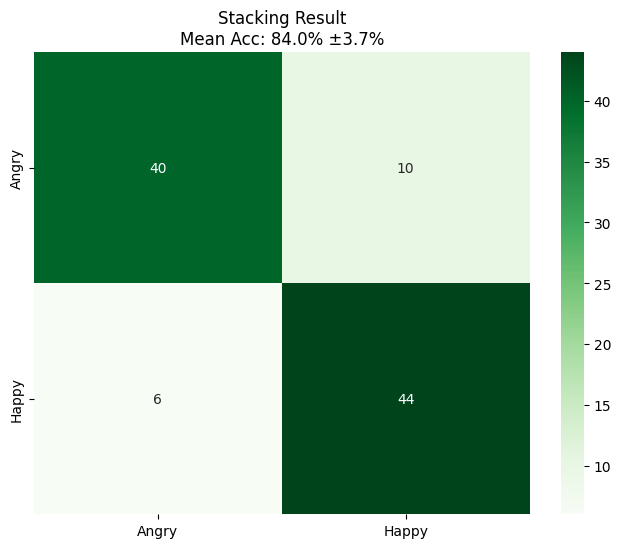


🎯 Weighted F1 Score : 0.8397
🎯 Macro F1 Score    : 0.8397

⚖️ ANALISIS KONTRIBUSI FITUR
🔊 Audio Score : 0.9487
📝 Text Score  : 0.2897
👉 Persentase  : Audio 76.6% vs Text 23.4%

💾 Saving Final Models...
✅ Model Stage 2A (Angry/Happy) berhasil disimpan & di-log ke MLflow.


In [12]:
# --- 3. STACKING TRAINING (STRUKTUR TETAP) ---
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
acc_scores = []
y_true_all = []
y_pred_all = []
meta_weights = []

print(f"\n🚀 START STACKING TRAINING ({FOLDS}-Fold)...")

# Variabel untuk menyimpan model terakhir (untuk saving)
clf_audio_final = None
meta_clf_final = None

with mlflow.start_run(run_name=f"Stacking_Seed{SEED}_{FOLDS}Fold"):
    # Log Global Params
    mlflow.log_params({
        "folds": FOLDS,
        "seed": SEED,
        "base_model": "RandomForest_200",
        "meta_model": "LogisticRegression_0.1",
        "audio_features": "YAMNet+RMS+ZCR"
    })

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_audio_features, y_labels)):
        
        X_aud_tr, X_aud_ts = X_audio_features[train_idx], X_audio_features[test_idx]
        y_tr, y_ts = y_labels[train_idx], y_labels[test_idx]
        X_txt_tr = X_text_scores[train_idx]
        X_txt_ts = X_text_scores[test_idx]
        
        # Base Model: Audio (Random Forest n=200)
        clf_audio = RandomForestClassifier(
            n_estimators=200,
            max_depth=5,
            min_samples_leaf=4,
            max_features='sqrt',
            random_state=SEED
        )
        clf_audio.fit(X_aud_tr, y_tr)
        
        prob_audio_train_cv = cross_val_predict(clf_audio, X_aud_tr, y_tr, cv=3, method='predict_proba')
        prob_audio_test = clf_audio.predict_proba(X_aud_ts)
        
        # Meta Learner Input
        X_meta_train = np.concatenate([prob_audio_train_cv, X_txt_tr], axis=1)
        X_meta_test = np.concatenate([prob_audio_test, X_txt_ts], axis=1)
        
        # Meta Learner: Logistic Regression
        meta_clf = LogisticRegression(C=0.1, solver='liblinear', random_state=SEED)
        meta_clf.fit(X_meta_train, y_tr)
        
        meta_weights.append(meta_clf.coef_[0]) 
        y_pred_fold = meta_clf.predict(X_meta_test)
        
        acc = accuracy_score(y_ts, y_pred_fold)
        acc_scores.append(acc)
        print(f"   Fold {fold+1}: {acc*100:.2f}%")
        
        mlflow.log_metric(f"fold_{fold+1}_acc", acc)
        
        y_true_all.extend(y_ts)
        y_pred_all.extend(y_pred_fold)
        
        # Simpan referensi model terakhir
        clf_audio_final = clf_audio
        meta_clf_final = meta_clf

    # --- 4. REPORT & ANALYSIS ---
    mean_acc = np.mean(acc_scores) * 100
    std_acc = np.std(acc_scores) * 100

    print("\n" + "="*50)
    print("📊 HASIL AKHIR & KESTABILAN")
    print("="*50)

    print(f"🏆 Rata-rata Akurasi : {mean_acc:.2f}%")
    print(f"📉 Standar Deviasi   : ±{std_acc:.2f}%")
    if std_acc < 5.0:
        print("   ✅ STATUS: SANGAT STABIL")
    elif std_acc < 10.0:
        print("   ⚠️ STATUS: CUKUP STABIL (Normal)")
    else:
        print("   ❌ STATUS: TIDAK STABIL (Hasil fluktuatif)")

    print("-" * 50)
    print(classification_report(y_true_all, y_pred_all, target_names=['angry', 'happy']))

    # Plot CM
    cm = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Angry','Happy'], yticklabels=['Angry','Happy'])
    plt.title(f'Stacking Result\nMean Acc: {mean_acc:.1f}% ±{std_acc:.1f}%')
    cm_path = 'results/cm_exp27_robustness.png'
    plt.savefig(cm_path)
    plt.show()

    # Hitung F1 dari seluruh CV result
    weighted_f1 = f1_score(y_true_all, y_pred_all, average='weighted')
    macro_f1 = f1_score(y_true_all, y_pred_all, average='macro')

    print(f"\n🎯 Weighted F1 Score : {weighted_f1:.4f}")
    print(f"🎯 Macro F1 Score    : {macro_f1:.4f}")

    mlflow.log_metric("weighted_f1", weighted_f1)
    mlflow.log_metric("macro_f1", macro_f1)

    # --- 5. ANALISIS BOBOT ---
    print("\n⚖️ ANALISIS KONTRIBUSI FITUR")
    avg_weights = np.mean(meta_weights, axis=0)
    audio_contrib = abs(avg_weights[0]) + abs(avg_weights[1])
    text_contrib  = abs(avg_weights[2]) + abs(avg_weights[3])

    print(f"🔊 Audio Score : {audio_contrib:.4f}")
    print(f"📝 Text Score  : {text_contrib:.4f}")

    total = audio_contrib + text_contrib
    if total > 0:
        print(f"👉 Persentase  : Audio {(audio_contrib/total)*100:.1f}% vs Text {(text_contrib/total)*100:.1f}%")

    # --- 6. SAVING MODEL (SESUAI REQUEST) ---
    print("\n💾 Saving Final Models...")
    if clf_audio_final is not None and meta_clf_final is not None:
        if not os.path.exists('models'):
            os.makedirs('models')
            
        rf_path = '../../../models/v3/stage2a_rf.pkl'
        meta_path = '../../../models/v3/stage2a_meta.pkl'
        joblib.dump(clf_audio_final, rf_path)
        joblib.dump(meta_clf_final, meta_path)
        
        # Log to MLflow
        mlflow.log_metric("mean_accuracy", mean_acc / 100)
        mlflow.log_artifact(cm_path)
        mlflow.log_artifact(rf_path)
        mlflow.log_artifact(meta_path)
        
        print(f"✅ Model Stage 2A (Angry/Happy) berhasil disimpan & di-log ke MLflow.")
    else:
        print("❌ Gagal menyimpan model (Training loop tidak berjalan?)")